# Importing libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.svm import SVR
import sklearn
import math
import statistics
import seaborn as sns
import pickle
import datetime
import os

# Global variables

In [2]:
PRED_HOUR = 0
LOOKBACK = 80
TEST_PERIOD = 30
HOUR = 18
YEAR = 1997
GAMMA = 0.3
EMA = 0.0
basedir = os.getcwd()

# Defining custom functions

In [3]:
def load_data(year: int, hour: int):
    if year >= 1985:
        year -= 1985
    """
    Returns df for that particular year and hour
    """
    assert hour in range(24), "Hour should be between 0 and 23"
    assert year in range(30), "Year should be between 0 and 30"
    _path = os.path.join(basedir, "dataset", "complete_dataset", "hour-{}-year-{}.pickle".format(hour, year))
    if os.path.isfile(_path):
        with open(_path, "rb") as f:
            return pickle.load(f)
    else:
        raise FileNotFoundError("File not found at {}".format(_path))


def generate_date_list(start, end=None, length=None):
    start_date = datetime.datetime.strptime(start, "%d-%m-%Y")
    if end is not None:
        end = datetime.datetime.strptime(end, "%d-%m-%Y")
        delta = end - start_date
        return [datetime.datetime.strftime(start_date + datetime.timedelta(i), "%d-%m-%Y") for i in range(delta.days)]
    elif length is not None:
        return [datetime.datetime.strftime(start_date + datetime.timedelta(i), "%d-%m-%Y") for i in range(length)]
    else:
        raise ValueError("At least one of end or length must be provided")


def get_ema(_list, ema=0.0, gamma=0.3):
    EMA = 0.0
    gamma = 0.3
    for ti in range(len(_list)):
      EMA = gamma*_list[ti] + (1-gamma)*EMA
      _list[ti] = EMA
    return _list

# Loading dataset

In [4]:
df = load_data(YEAR, HOUR)
cols = df.columns
df.reset_index(inplace=True)
df = df[cols]

# Preprocessing Dataset

In [5]:
df["Date"] = pd.Series(generate_date_list("1-1-{}".format(YEAR), length=len(df)))

# Getting EMA for data

In [6]:
ema_mean = get_ema(df["mean"].values.tolist())

# Plotting the entire data

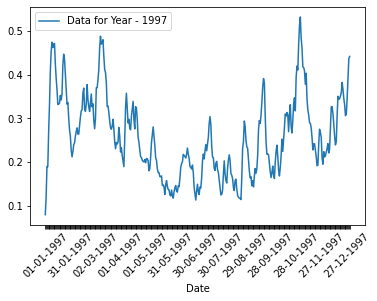

In [7]:
fig, ax = plt.subplots()
sns.lineplot(
    x = df["Date"][len(df)-len(ema_mean):], 
    y = ema_mean,
    label="Data for Year - {}".format(YEAR)
)
plt.xticks(rotation = 45)
every_nth = 30
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.show()

# Splitting the dataset

In [8]:
train, test = ema_mean[:len(ema_mean)-TEST_PERIOD], ema_mean[len(ema_mean) - TEST_PERIOD:]

In [9]:
print(len(train), len(test))

335 30


# Recurrent Neural network


## Making data in correct format

In [10]:
# Scaling data
train = np.array(train).reshape(-1,1)
test = np.array(test).reshape(-1,1)
rnn_scaler = MinMaxScaler()
train = rnn_scaler.fit_transform(train)
test = rnn_scaler.transform(test)

In [11]:
# Making data chunks
X_train = []
y_train = []
for i in range(LOOKBACK, len(train)-1):
    X_train.append(train[i-LOOKBACK:i])
    y_train.append(train[i+1])

In [12]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [13]:
X_test = []
y_test = []
for i in range(X_train.shape[0], X_train.shape[0] + len(test) - 1):
    # print("Appending")
    X_test.append(ema_mean[i-LOOKBACK:i])
    y_test.append(ema_mean[i+1])

In [14]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [15]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(254, 80, 1) (29, 80) (254, 1) (29,)


In [16]:
regressor = keras.Sequential()

regressor.add(keras.layers.LSTM(units = 128, return_sequences = True, input_shape=(LOOKBACK,1)))
regressor.add(keras.layers.Dropout(0.2))

regressor.add(keras.layers.LSTM(units = 64, return_sequences = True))
regressor.add(keras.layers.Dropout(0.15))

regressor.add(keras.layers.LSTM(units = 32, return_sequences = True))
regressor.add(keras.layers.Dropout(0.15))

regressor.add(keras.layers.LSTM(units = 64, return_sequences = False))
regressor.add(keras.layers.Dropout(0.15))

regressor.add(keras.layers.Dense(units=64,activation='relu'))
regressor.add(keras.layers.Dense(units=32,activation='relu'))
regressor.add(keras.layers.Dense(units=16,activation='relu'))
regressor.add(keras.layers.Dense(units=8,activation='tanh'))
regressor.add(keras.layers.Dense(units=1))

regressor.compile(optimizer='adam',loss="mean_squared_error",metrics=["accuracy"])
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 80, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 80, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 80, 64)            49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 80, 32)            12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                2

In [17]:
history = regressor.fit(x=X_train, y=y_train, batch_size=64, epochs=50, use_multiprocessing=True)

Epoch 1/50
4/4 [==============================] - 6s 178ms/step - loss: 0.1100 - accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 1s 171ms/step - loss: 0.0430 - accuracy: 0.0016
Epoch 3/50
4/4 [==============================] - 1s 167ms/step - loss: 0.0283 - accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 1s 179ms/step - loss: 0.0298 - accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 1s 205ms/step - loss: 0.0247 - accuracy: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 1s 214ms/step - loss: 0.0287 - accuracy: 0.0000e+00
Epoch 7/50
4/4 [==============================] - 1s 203ms/step - loss: 0.0310 - accuracy: 0.0000e+00
Epoch 8/50
4/4 [==============================] - 1s 197ms/step - loss: 0.0264 - accuracy: 0.0000e+00
Epoch 9/50
4/4 [==============================] - 1s 169ms/step - loss: 0.0235 - accuracy: 0.0000e+00
Epoch 10/50
4/4 [==============================] - 1s 177ms/step - loss: 0.0238 - accu

In [18]:
rnn_predicted = regressor.predict(np.array(X_test).reshape(-1, LOOKBACK, 1))
rnn_predicted = rnn_scaler.inverse_transform(rnn_predicted)

# Support Vector Machine Regressor

In [19]:
svm_regressor = SVR(kernel = 'rbf')

In [20]:
history = svm_regressor.fit(X_train.reshape(-1,LOOKBACK), y_train)

/home/animesh/Projects/wind/pythonenv/lib64/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [21]:
svm_predicted = svm_regressor.predict(X_test)
svm_predicted = rnn_scaler.inverse_transform(svm_predicted.reshape(1,-1))

# Plotting the results

<ipython-input-22-62f81a852a1c>:2: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  ax = fig.add_axes()


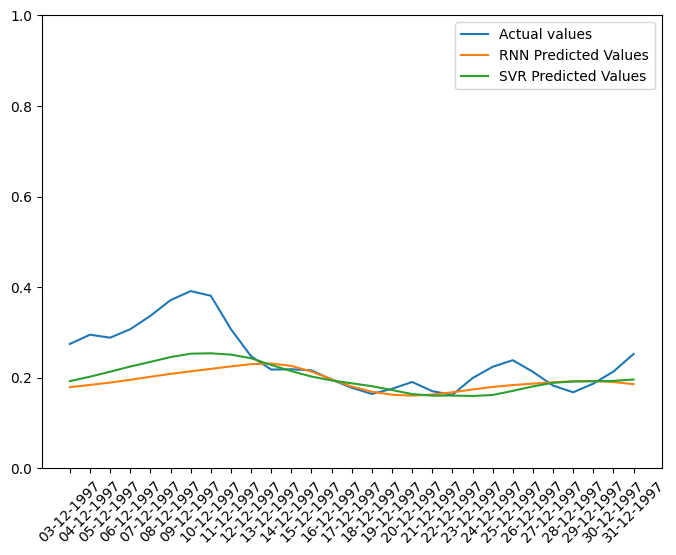

In [22]:
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_axes()
plt.plot(df["Date"][len(df) - TEST_PERIOD + 1:].values.tolist(), y_test, label="Actual values")
plt.plot(rnn_predicted, label="RNN Predicted Values")
plt.plot(svm_predicted.reshape(-1), label="SVR Predicted Values")
plt.ylim(0, 1)
plt.xticks(rotation = 45)
plt.legend()
plt.show()

# Validating the results

In [23]:
rnn_mse = sklearn.metrics.mean_squared_error(y_test, rnn_predicted.reshape(-1).tolist())
rnn_rmse = math.sqrt(rnn_mse)

In [24]:
svm_mse = sklearn.metrics.mean_squared_error(y_test, svm_predicted.reshape(-1).tolist())
svm_rmse = math.sqrt(svm_mse)

In [25]:
print(rnn_rmse, svm_rmse)

0.07568063607911206 0.06133962978723968


In [26]:
rnn_stdev = statistics.stdev(rnn_predicted.reshape(-1).tolist())
svm_stdev = statistics.stdev(svm_predicted.reshape(-1).tolist())

In [27]:
print(rnn_stdev, svm_stdev)

0.02083726436244035 0.03025168611503389
